In [1]:
from config import *

import bs4
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from typing_extensions import List, TypedDict, Annotated
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage, trim_messages

/Users/zhengjie/Documents/learn-langchain/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
USER_AGENT environment variable not set, consider setting it to identify your requests.


# 获取网页内容

这一部分我们将从网页中提取文本，然后将其分成小块，以便逐步翻译。

In [2]:
bs4_strainer = bs4.SoupStrainer(class_=("md-content__inner md-typeset"))
loader = WebBaseLoader(
    web_paths=("https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # chunk size (characters)
    chunk_overlap=0,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document

)
all_splits = text_splitter.split_documents(docs)

# 建立翻译机制

我们将使用一个简单的状态机来处理翻译任务。我们将从一个系统消息开始，制定翻译规则，然后逐步翻译文档的每个部分。

In [3]:
prompt = SystemMessage("您是一名精通多领域的技术文档翻译专家，需要将英文技术文档翻译成中文。\n"
                       "你需要遵循以下规则:\n"
                       "1. 使用Markdown格式对文档进行排版，各级标题需要使用相应的格式（如“#”、“##”），这一点很重要。\n"
                       "2. 有关代码的部分不需要进行翻译，包括代码的注释。\n"
                       "3. 只需要翻译我给你的内容，不要去创作、不要闲聊。\n"
                       "4. 请尽量保持翻译的准确性和流畅性。\n"
                       "最后，再次提醒，翻译的结果要用Markdown格式。\n")

In [4]:
class State(TypedDict):
    num: int
    translated_splits: Annotated[List[AnyMessage], add_messages]
    messages: Annotated[List[AnyMessage], add_messages]
    translated: str

In [5]:
def ask_for_translation(state: State):
    return {
        "messages": [HumanMessage(all_splits[state['num']].page_content)]
    }


def translate(state: State):
    messages = trim_messages(state['messages'],
                             max_tokens=3,
                             token_counter=len,
                             start_on="human",
                             end_on="human")

    # 每次传递的消息都是从当前状态开始（包含了 prompt 和之前的翻译）
    messages = [prompt] + messages

    # 获取模型的响应
    response = llm.invoke(messages)

    # 修复：确保我们只将当前翻译的结果返回，而不重复之前的翻译
    return {
        "messages": [response],
        "translated_splits": [response],  # 只返回当前分块的翻译
        "num": state['num'] + 1  # 更新索引，确保不会重复处理已翻译的分块
    }


def collect(state: State):
    return {
        "translated": "\n".join([m.content for m in state['translated_splits']])
    }


def route(state: State):
    # 当所有分块都已翻译时，结束处理
    if state['num'] < len(all_splits):
        return "ask_for_translation"
    else:
        return "collect"

构建状态图，添加节点和边

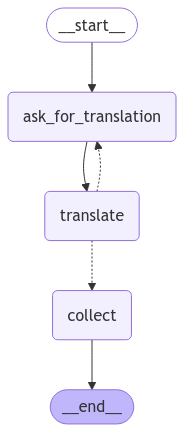

In [6]:
# 初始化 LLM 模型
llm = ChatOpenAI(model="qwen-max")

# 创建状态图
graph_builder = StateGraph(State)
graph_builder.add_node("ask_for_translation", ask_for_translation)
graph_builder.add_node("translate", translate)
graph_builder.add_node("collect", collect)

# 定义节点之间的流动关系
graph_builder.add_edge(START, "ask_for_translation")
graph_builder.add_edge("ask_for_translation", "translate")
graph_builder.add_conditional_edges("translate", route,
                                    {"ask_for_translation": "ask_for_translation",
                                     "collect": "collect"})
graph_builder.add_edge("collect", END)

# 编译状态图
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# 展示翻译结果

In [7]:
# 流式执行并打印每个步骤的输出
inputs = {"num": 0, "translated_splits": [], "messages": []}
result = graph.invoke(inputs)

In [8]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Prompt Generation from User Requirements¶
In this example we will create a chat bot that helps a user generate a prompt.
It will first collect requirements from the user, and then will generate the prompt (and refine it based on user input).
These are split into two separate states, and the LLM decides when to transition between them.
A graphical representation of the system can be found below.

Setup¶
First, let's install our required packages and set our OpenAI API key (the LLM we will use)
%%capture --no-stderr
% pip install -U langgraph langchain_openai

import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")


Set up LangSmith for LangGraph development

        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace dat

In [9]:
from IPython.display import Markdown, display

display(Markdown(result["translated"]))

# 从用户需求生成提示
在这个示例中，我们将创建一个聊天机器人，帮助用户生成一个提示。
它首先会从用户那里收集需求，然后生成提示（并根据用户输入进行优化）。
这些过程被分为两个独立的状态，而LLM将决定何时在这两者之间切换。
下面是一个系统的图形表示。

## 设置
首先，让我们安装所需的包并设置我们的OpenAI API密钥（我们将使用的LLM）
```python
%%capture --no-stderr
% pip install -U langgraph langchain_openai

import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
```

### 设置LangSmith以支持LangGraph开发
注册LangSmith可以快速发现问题并改进您的LangGraph项目。LangSmith允许您使用跟踪数据来调试、测试和监控使用LangGraph构建的LLM应用程序 —— [了解更多关于如何开始的信息](这里)。

## 收集信息
首先，让我们定义图的一部分，该部分将收集用户需求。这将是一个带有特定系统消息的LLM调用。它将能够访问一个工具，在准备好生成提示时可以调用该工具。

### 使用Pydantic与LangChain
本笔记本使用了Pydantic v2的BaseModel，这需要langchain-core >= 0.3。如果使用langchain-core < 0.3，则会导致Pydantic v1和v2 BaseModel混合导致错误。

```python
from typing import List

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel

API参考: SystemMessage | ChatOpenAI
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:
"""
```

- 提示的目标是什么
- 将传递给提示模板的变量有哪些
- 输出不应该做什么的任何限制
- 输出必须遵守的任何要求

如果您无法明确这些信息，请让他们澄清！不要随意猜测。

在您能够明确所有信息后，调用相关的工具。


```python
def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """关于如何向LLM发出提示的说明。"""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}
```

## 生成提示
我们现在设置将生成提示的状态。
这需要一个单独的系统消息，以及一个函数来过滤掉工具调用之前的所有消息（因为这是前一个状态决定生成提示的时候）。

```python
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# 新的系统提示
prompt_system = """基于以下需求，编写一个好的提示模板：

{reqs}"""


# 获取提示消息的函数
# 只获取工具调用之后的消息
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs
```
```python
def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

# API 参考: AIMessage | HumanMessage | ToolMessage
## 定义状态逻辑
这是聊天机器人所处状态的逻辑。
如果最后一条消息是工具调用，那么我们处于“提示创建者”（prompt）应该响应的状态。
否则，如果最后一条消息不是HumanMessage，那么我们知道接下来应该是人类响应，所以我们处于END状态。
如果最后一条消息是HumanMessage，那么如果有之前的工具调用，我们就处于提示状态。
否则，我们处于“信息收集”（info）状态。

from typing import Literal

from langgraph.graph import END


def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

# API 参考: END
## 创建图
我们现在可以创建图。
我们将使用SqliteSaver来持久化对话历史记录。
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


memory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }
```
```markdown
workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

# API 参考: MemorySaver | StateGraph | START | add_messages
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 使用图
我们现在可以使用创建的聊天机器人。
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("用户 (q/Q 退出): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"用户 (q/Q 退出): {user}")
    if user in {"q", "Q"}:
        print("AI: 再见")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("完成!")

用户 (q/Q 退出): hi!
==================================[1m Ai 消息 [0m==================================

你好！今天我能帮你什么？

用户 (q/Q 退出): rag prompt
==================================[1m Ai 消息 [0m==================================

当然！我可以帮助你创建一个提示模板。首先，请提供以下信息：

1. 提示的目标是什么？
2. 将传递到提示模板中的变量有哪些？
3. 输出不应做什么的任何约束条件？
4. 输出必须遵守的任何要求？
```
```markdown
一旦我获得了这些信息，我就可以帮助你创建提示模板。
用户 (q/Q 退出): 1 rag, 2 none, 3 no, 4 no
==================================[1m Ai 消息 [0m==================================
工具调用:
  PromptInstructions (call_tcz0foifsaGKPdZmsZxNnepl)
 调用 ID: call_tcz0foifsaGKPdZmsZxNnepl
  参数:
    目标: rag
    变量: ['none']
    约束条件: ['no']
    要求: ['no']
=================================[1m 工具消息 [0m=================================

提示已生成！
==================================[1m Ai 消息 [0m==================================

请使用 RAG（红色、琥珀色、绿色）评级系统编写回复。
完成!
用户 (q/Q 退出): red
==================================[1m Ai 消息 [0m==================================

回复: 状态为红色。
用户 (q/Q 退出): q
AI: 再见




        这个页面有帮助吗？
      











              
              
                
              
              感谢您的反馈！
            

              
              
                
              
              感谢您的反馈！请通过在下面的讨论中添加内容来帮助我们改进此页面。
            




评论
```